In [ ]:
import math

from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon

wavelength_range = [550 * 2 , 900 *2]  # pump wavelength = SHG wavelength *2
wavelegnth_step = 30
ray = "o"

n_core = lambda w: n_LNOI(w, ray=ray)
n_buffer = n_SiO2
n_air = n_Air

# waveguide parameters
#bottom_width = 2 # um
top_width = 1.15
box_height = 5
triangle_height = 0.6
triangle_width = triangle_height/ math.tan(60 * math.pi /180)

# Construct waveguide geometry
"""
core = Polygon([(bottom_width/2,0 ),(-bottom_width/2, 0),(-bottom_width/2 + triangle_width, triangle_height) , (bottom_width/2 - triangle_width, triangle_height)])
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)
"""
core = Polygon([(top_width/2 + triangle_width,0 ),(-top_width/2-triangle_width, 0),(-top_width/2, triangle_height) , (top_width/2, triangle_height)])
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)

polygon = OrderedDict(
    core = core,
    buffer = buffer,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.02, "distance": 0.1},
                   buffer={"resolution": 0.1, "distance": 0.5},
                   air={"resolution": 0.1, "distance": 0.5})

n_dict = {"core": n_core, "buffer": n_buffer, "air": n_air}

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

#----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.linspace(wavelength_range[0], wavelength_range[1], wavelegnth_step)
neff_list_te = []
aeff_list_te = []
neff_list_tm = []
aeff_list_tm = []

for wavelength in tqdm(wavelength_list):
    wavelength = wavelength * 1e-3
    for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
    ## te mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
    mode = modes_sorted[0]
    neff_list_te.append(np.real(mode.n_eff))
    aeff_list_te.append(mode.calculate_effective_area())

    ## tm mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
    if modes_sorted[0].tm_fraction < 0.7:
        print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
    mode = modes_sorted[0]
    neff_list_tm.append(np.real(mode.n_eff))
    aeff_list_tm.append(mode.calculate_effective_area())

neff_list_te = np.array(neff_list_te)
aeff_list_te = np.array(aeff_list_te)
neff_list_tm = np.array(neff_list_tm)
aeff_list_tm = np.array(aeff_list_tm)
wls = np.array(wavelength_list)

##save data
np.savez(f"data_h_{triangle_height}_w_{top_width}_{ray}", wls=wls, aeff_list_te=aeff_list_te, neff_list_te=neff_list_te, neff_list_tm=neff_list_tm,aeff_list_tm=aeff_list_tm)

print("end")

print(wls)

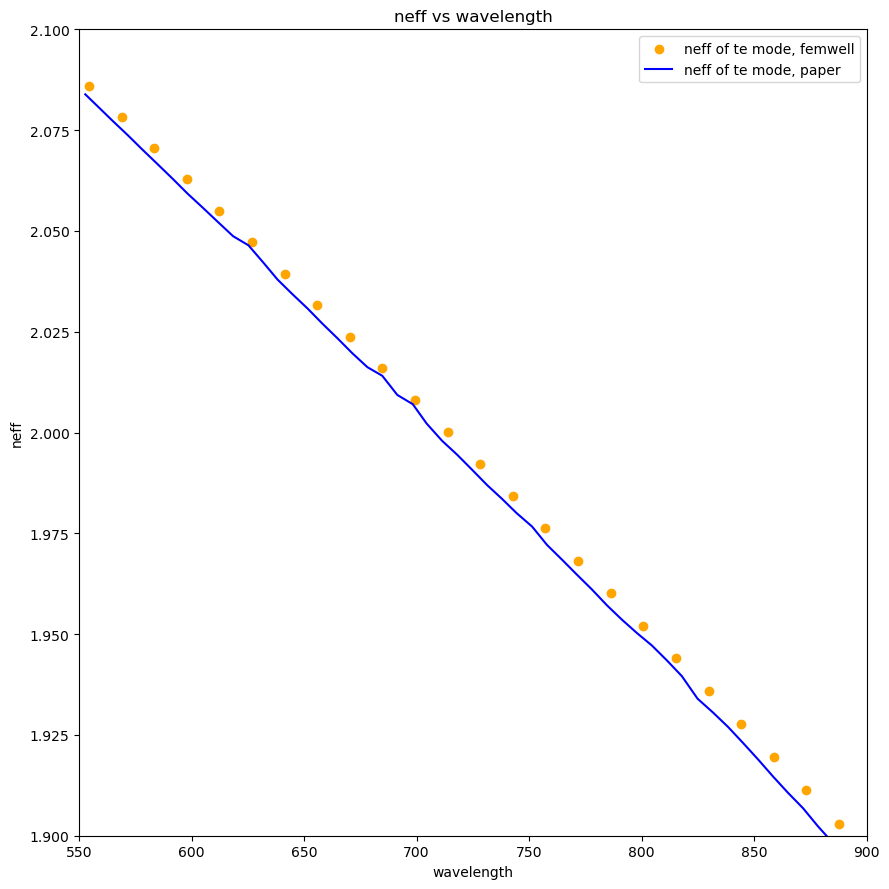

In [5]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd
# waveguide parameters
#bottom_width = 2 # um
top_width = 1.15
box_height = 5
triangle_height = 0.6
ray = "o"


data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
neff_list_te = np.array(np.real(data['neff_list_te']))
wls = data["wls"]/2

fig, axs = plt.subplots(1, 1, figsize=(9,9))

#-----------neff plot-----------------
axs.set_xlabel("wavelength")
axs.set_ylabel("neff")
axs.set_title("neff vs wavelength")
axs.scatter(wls,neff_list_te, color="orange", label = "neff of te mode, femwell")


#-----------plot reference data __________________
ref = pd.read_csv("../reference_data/figure4b.csv", dtype=np.float64)
ref_x, ref_y = np.split(ref.values, 2, axis=1)
axs.plot(ref_x, ref_y, c="blue", label = "neff of te mode, paper")
axs.set_xlim(550,900)
axs.set_ylim(1.9,2.1)
axs.legend()
plt.tight_layout()
plt.show()